# FIFA Crawling

**Authors: ** Jocaz Entico, Sashmir Yap

### Executive Summary
In this notebook, we will be clustering the FIFA World Cup 2018 Players by implementing K-Means Clustering. K-Means is a representative-based clustering method where the representative of each cluster is determined by getting the mean of the points in the given cluster. All players are listed in the [official FIFA website](https://www.fifa.com/worldcup/players/_libraries/byposition/all/_players-list) where you can find the player's position and their statistics. Based on the data that we crawled on the website, we can group the players by their position and consider this as the **Ground Truth** for the clusters of the players. Comparing the results of the K-Means Clustering, we can observe that the optimal $k = 4$. The 4 clusters are:

- Cluster 1 - forward players 
- Cluster 2 - players with low statistics(noob players) 
- Cluster 3 - defenders and midfielders
- Cluster 4 - players who frequently receive red cards(bad players) 

## Preliminaries

In [32]:
import pandas as pd 
import numpy as np 
import requests
import pandas as pd
import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from pandas.plotting import parallel_coordinates
from math import pi

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

## Web Crawler Implementation

A web crawler was created in order to scrape the data from the FIFA website. In order to do this a 2-step approach was done. First was to gather all the player ids and position. Second was to get the player statistics based on the player id and save it to a csv file. 

In [2]:
# response = requests.get('https://www.fifa.com/worldcup/players/_libraries/byposition/all/_players-list')
# html=response.text
# soup=BeautifulSoup(html,'html.parser')
# rows = soup.find_all(class_='fi-p--link ')
# player_ids = []
# df_player = pd.DataFrame()

# for row in rows: 
#     player = {
#         'id': row['data-player-id'],
#         'role': row.find('div', class_='fi-p__role').text.strip()
#     }
#     df_player = df_player.append(player, ignore_index=True)
    
# headers = {
#     'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Mobile Safari/537.36'
# }

# df = pd.DataFrame()
# for index, player in df_player.iterrows():
#     link = 'https://www.fifa.com/worldcup/_libraries/players/player/%s/_player-statistics' % player['id']
#     response = requests.get(link, headers=headers)
    
#     if len(response.content) > 10: 
#         html=response.content
#         soup=BeautifulSoup(html,'html.parser')

#         rows = soup.find_all('div', class_='fi-p__profile-number')
#         player_stats = {'Player Id': player['id'], 'Position': player['role']}
#         for row in rows:
#             res = row.text.split()
#             player_stats[' '.join(res[1:])] = res[0]
#         df = df.append(player_stats, ignore_index=True)

## Dataset Description

A total of 604 players were scrape from the website consisting of 51 player's statistics.

In [3]:
df_fifa = pd.read_csv('fifa_player_stats_new.csv')
df_fifa.columns = map(lambda x:x.replace(' ', '_').lower(),df_fifa.columns)
player_positions = df_fifa['position']
df_fifa.head()

,assists,attempts,attempts_off_target,attempts_on_target,attempts_against_woodwork,attempts_inside_the_area,attempts_on_target_from_inside_the_area,attempts_on_target_from_outside_the_area,attempts_outside_the_area,blocks,...,saves,short_passes_completed,shots_blocked,shots_from_free-kick,tackles,tackles_suffered,tackles_won,throws,total_passes,yellow_cards
0,0,3,1,0,0,0,0,0,3,1,...,0,50,2,1,6,1,2,0,197,0
1,1,2,2,0,0,1,0,0,1,0,...,0,34,0,0,0,1,0,0,142,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,2,4,0
3,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,6,34,0
4,1,2,0,0,0,1,0,0,1,0,...,0,86,2,0,3,2,1,0,268,0


## Data Preprocessing

Observing the data we see that there are some columns in percentage format. We fix this by converting it to float type. 

In [4]:
df_fifa['save_rate'] = df_fifa['save_rate'].str.rstrip('%').astype('float') / 100.0
df_fifa['goal_kicks_successfully_reaching_a_team-mate'] = df_fifa['goal_kicks_successfully_reaching_a_team-mate'].str.rstrip('%').astype('float') / 100.0

We use min-max scaler for visualization purposes later since different have different units. 

In [5]:
scaler = MinMaxScaler()
columns = list(df_fifa.columns)
columns.remove('position')
df_fifa_scaled = scaler.fit_transform(df_fifa.drop(['position'],axis=1))
df_fifa_scaled = pd.DataFrame(df_fifa_scaled, columns=columns)
df_fifa_scaled.head()

,assists,attempts,attempts_off_target,attempts_on_target,attempts_against_woodwork,attempts_inside_the_area,attempts_on_target_from_inside_the_area,attempts_on_target_from_outside_the_area,attempts_outside_the_area,blocks,...,saves,short_passes_completed,shots_blocked,shots_from_free-kick,tackles,tackles_suffered,tackles_won,throws,total_passes,yellow_cards
0,0.0,0.111111,0.076923,0.0,0.0,0.000000,0.0,0.0,0.200000,0.083333,...,0.00,0.331126,0.222222,0.166667,0.3750,0.05,0.250,0.000000,0.388560,0.0
1,0.5,0.074074,0.153846,0.0,0.0,0.058824,0.0,0.0,0.066667,0.000000,...,0.00,0.225166,0.000000,0.000000,0.0000,0.05,0.000,0.000000,0.280079,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.00,0.013245,0.000000,0.000000,0.0000,0.00,0.000,0.031746,0.007890,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.08,0.000000,0.000000,0.000000,0.0000,0.00,0.000,0.095238,0.067061,0.0
4,0.5,0.074074,0.000000,0.0,0.0,0.058824,0.0,0.0,0.066667,0.000000,...,0.00,0.569536,0.222222,0.000000,0.1875,0.10,0.125,0.000000,0.528600,0.0


## Clustering Time!! 

We cluster the data using K-means clustering on the following features recommended by Prof Alis: 

- matches played
- minutes played
- goals scored 
- assists
- attempts on target 
- attempts off target 
- offsides 
- passes completed 
- fouls committed 
- fouls suffered
- yellow cards 
- red cards

### Handpicked Features 

In [38]:
x_features = df_fifa_scaled[['matches_played', 'minutes_played', 'goals_scored',
                      'assists', 'attempts_on_target', 'attempts_off_target',
                      'offsides', 'passes_completed', 'fouls_committed',
                      'fouls_suffered', 'yellow_cards', 'red_cards']]
x_features['position'] = df_fifa['position']
x_features.head()

,matches_played,minutes_played,goals_scored,assists,attempts_on_target,attempts_off_target,offsides,passes_completed,fouls_committed,fouls_suffered,yellow_cards,red_cards,position
0,0.4,0.446103,0.0,0.0,0.0,0.076923,0.000000,0.348454,0.210526,0.038462,0.0,0.0,Midfielder
1,0.4,0.369818,0.0,0.5,0.0,0.153846,0.000000,0.228866,0.000000,0.038462,0.0,0.0,Midfielder
2,0.2,0.048093,0.0,0.0,0.0,0.000000,0.166667,0.006186,0.052632,0.000000,0.0,0.0,Forward
3,0.0,0.147595,0.0,0.0,0.0,0.000000,0.000000,0.039175,0.000000,0.000000,0.0,0.0,Goalkeeper
4,0.4,0.402985,0.0,0.5,0.0,0.000000,0.000000,0.513402,0.105263,0.307692,0.0,0.0,Midfielder


## Ground Truth

We cosnidered ground truth to be the player's positions, namely, forward, defender, midfield and goal keeper. In order to visualize the player statistics distribution of the different positions we used a radar chart.

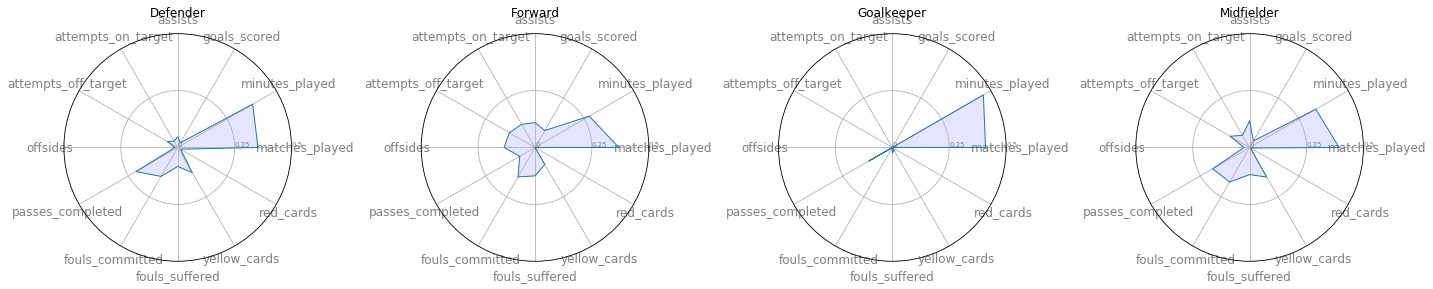

In [39]:
agg_fifa_df = x_features.groupby('position', as_index=False).mean()
agg_fifa_df.head()
categories = list(agg_fifa_df)[1:]
N = len(categories)
fig = plt.figure(figsize=(20,12))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1, polar=True)
    
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=agg_fifa_df.loc[i].drop('position').values.flatten().tolist()
    values += values[:1]
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.25,0.5], ["0","0.25","0.5"], color="grey", size=7)
    plt.ylim(0,0.5)
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.set_title(agg_fifa_df['position'][i])
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.tight_layout()
    
fig.savefig('ground-radar-chart.png')

It can be observed that the matches and minutes played for all positions have relatively higher values compared to other features which is expected. Forward, excels on features that are related to scoring specifically goals scored. Defender and Midfielder, on the other hand, excels on passes completed. Lastly, the goal keeper's significant statistic is only passes completed. 

## K-Means

We implement k-means clustering, which is the simplest and most popular representative based clustering method to see if it would be able to determine clusters based on player's statistics.

In [67]:
def intra_to_inter(X, y, dist, r):
    """Compute intracluster to intercluster distance ratio
    
    Parameters
    ----------
    X : array
        Data matrix with each row corresponding to a point
    y : array
        Class label of each point
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    r : integer
        Number of pairs to sample
        
    Returns
    -------
    ratio : float
        Intracluster to intercluster distance ratio
    """
    dist_P = []
    dist_Q = []
#     np.random.seed(11)
    for i, j in np.random.randint(low=0, high=len(y), size=[r,2]):
        # just skip the pair even if we end up having pairs less than r
        if i == j:
            continue
        # intracluster
        elif y[i] == y[j]:
            dist_P.append(dist(X[i], X[j]))
        # intercluster
        else:
            dist_Q.append(dist(X[i], X[j]))
    intra = np.sum(dist_P) / len(dist_P)
    inter = np.sum(dist_Q) / len(dist_Q)
    ratio = intra / inter
    return ratio

In [24]:
x_features = df_fifa[['matches_played', 'minutes_played', 'goals_scored',
                      'assists', 'attempts_on_target', 'attempts_off_target',
                      'offsides', 'passes_completed', 'fouls_committed',
                      'fouls_suffered', 'yellow_cards', 'red_cards']]
scaler = StandardScaler()
x_features_scaled = scaler.fit_transform(x_features)

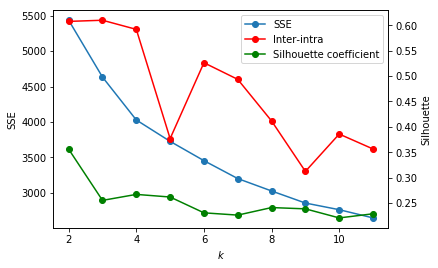

In [77]:
inertias = []
iidrs = []
scs = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i)
    y = kmeans.fit_predict(x_features_scaled)
    inertias.append(kmeans.inertia_)
    iidrs.append(intra_to_inter(x_features_scaled, y, euclidean, 50))
    scs.append(silhouette_score(x_features_scaled, y))

plt.plot(np.arange(2,12), inertias, '-o', label='SSE')
plt.xlabel('$k$')
plt.ylabel('SSE')
lines, labels = plt.gca().get_legend_handles_labels()
plt.twinx()
plt.plot(np.arange(2,12), iidrs, '-ro', label='Inter-intra')
plt.plot(np.arange(2,12), scs, '-go', label='Silhouette coefficient')
plt.ylabel('Silhouette')
lines2, labels2 = plt.gca().get_legend_handles_labels()
plt.legend(lines+lines2, labels+labels2);

We can observe that there is a decrease in the silhouette coefficient after k is equal to 4. On the other hand, there is increase in inter-intra ratio after k is equal to 5. Generally, the value of SSE is decreasing. Based on these factors we decided to use $k=4$.

In [83]:
x_features = df_fifa_scaled[['matches_played', 'minutes_played', 'goals_scored',
                      'assists', 'attempts_on_target', 'attempts_off_target',
                      'offsides', 'passes_completed', 'fouls_committed',
                      'fouls_suffered', 'yellow_cards', 'red_cards']]

kmeans = KMeans(n_clusters=4)
y = kmeans.fit_predict(x_features_scaled)
x_features['cluster'] = y+1

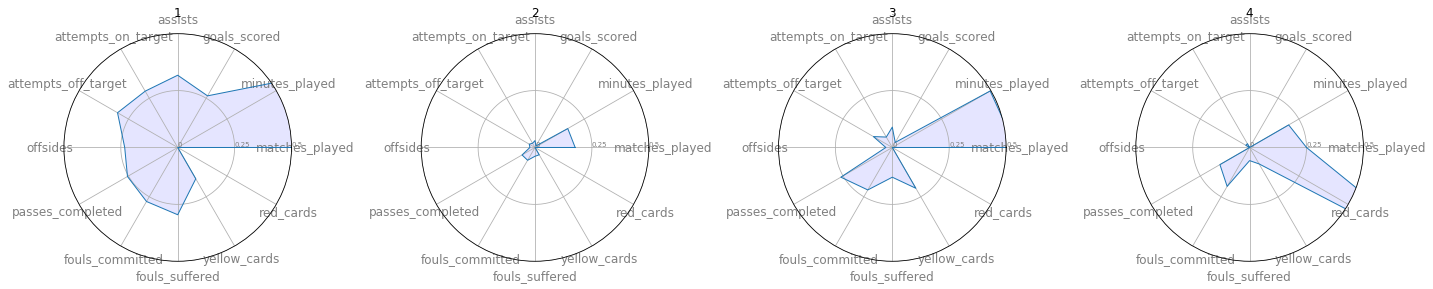

In [84]:
agg_fifa_df = x_features.groupby('cluster', as_index=False).mean()
agg_fifa_df.head()
categories = list(agg_fifa_df)[1:]
N = len(categories)
fig = plt.figure(figsize=(20,12))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1, polar=True)
    
    # We are going to plot the first line of the data frame.
    # But we need to repeat the first value to close the circular graph:
    values=agg_fifa_df.loc[i].drop('cluster').values.flatten().tolist()
    values += values[:1]
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0,0.25,0.5], ["0","0.25","0.5"], color="grey", size=7)
    plt.ylim(0,0.5)
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.set_title(agg_fifa_df['cluster'][i])
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    plt.tight_layout()

fig.savefig('cluster-radar-chart.png')

The clusters of k-means seem to deviate from the ground truth. In order to determine how it was clustered we check the proportion of each position for the different clusters.

## Check Proportions of Clusters

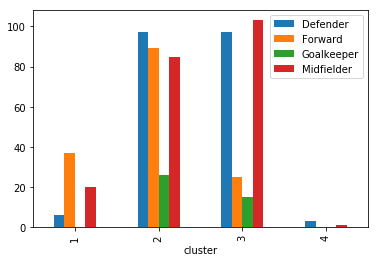

In [85]:
x_features['position'] = df_fifa['position']
x_features.head()
dummies = pd.get_dummies(x_features['position'])
dummies['cluster'] = x_features['cluster']
agg = dummies.groupby('cluster').sum()
agg.plot(kind='bar')
# agg_df = x_features.groupby('position')['cluster'].count()
# agg_df.head()

Things observed from the bar chart:
- cluster 1 is mainly composed of forwards 
- cluster 2 has the highest composition of goalkeepers
- cluster 3 is composed of mainly defenders and midfielders 
- cluster 4 has the lowest frequency among other clusters

## Results

<figure>
    <img src='ground-cluster-chart1.PNG'/>
    <figcaption style="text-align: center">Fig. 1. Ground Radar Chart Vs Cluster Radar Chart</figcaption>
</figure>

In conclusion we found out that using k-means clustering, the optimal $k=4$. The algorithm was able to cluster the FIFA world cup 2018 players based on the following: 

- Cluster 1 is composed of mostly forwards. It can also be observed that the radar chart of cluster 1 is close to the radar chart of forward position players.
- Cluster 2 is composed of players who have minimal contributions on the game. These players contribute through passing the ball.
- Cluster 3 is composed of defenders and midfielders who have high contribution to a game. This cluster has more passes, attempts on and off target relative to cluster 2.
- Cluster 4 is composed of players who frequently receive a red card which might explain why the minutes and matches played are relatively lower than the other clusters. 
